2017 Edition

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

In [12]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum([(p1[x]-p2[x])*(p1[x]-p2[x]) for x in range(len(p1))]))

# test our function
assert (np.round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

In [2]:
from scipy.spatial import distance
a = (1,2,3)
b = (4,5,6)
dst = distance.euclidean(a,b)
dst

import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return  distance.euclidean(p1,p2)

# test our function
assert (np.round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [86]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    lst = [euclidean_distance(datapoint, x) for x in centroids]
    minLst = np.min(lst)
    return lst.index(minLst)

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [87]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    index = np.arange(len(data))
    np.random.shuffle(index)
    kIndex = index[:k]
    centroids = [data[i] for i in range(len(data)) if i in kIndex]
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

In [88]:
MAX_ITERATIONS = 10

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if(num_iterations > MAX_ITERATIONS):
        return True
    # check if the centroids don't move (or very slightly)
    res = np.array([euclidean_distance(centroids[x],old_centroids[x])<=threshold for x in range(len(centroids))])
    if((res).all() ):
        return True
    else:
        return False

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [89]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    for x in range(len(cluster)):
        sumPoints = [0 for i in range(len(cluster[0][0]))]
        for y in range(len(cluster[x])):
            sumPoints = [np.sum(j) for j in zip(sumPoints,(cluster[x][y]))]
        centroids[x] = [a/len(cluster[x]) for a in sumPoints]
    return centroids

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

In [90]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):

    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data,k)
    print(centroids)
    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for point in data:
            # find the closest center of each data point
            #print(point)
            centroid_idx = find_closest_centroid(point, centroids)

            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(point)
            #print(clusters)
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]

        # update centroids
        centroids = update_centroids(old_centroids, clusters)

        # if the stop criteria are met, stop the algorithm
        if (check_converge(centroids, old_centroids, iterations)):
            break

    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


[array([ 4.6,  3.1,  1.5,  0.2]), array([ 4.6,  3.4,  1.4,  0.3]), array([ 5.7,  2.5,  5. ,  2. ])]


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


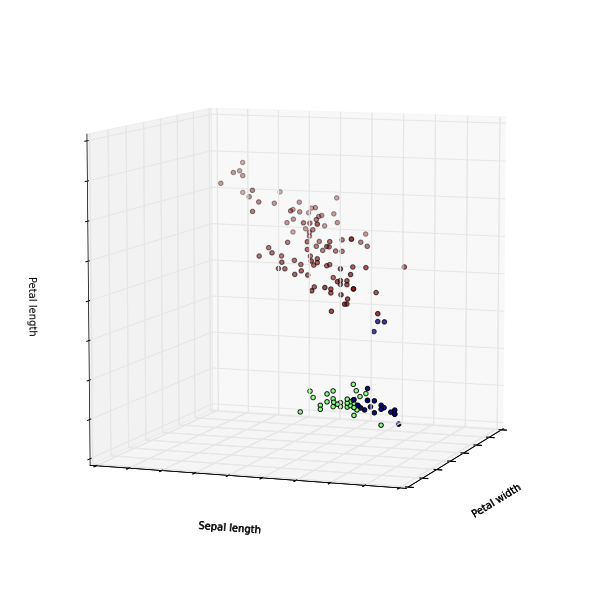

In [91]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297
np.random.seed(2)
%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_


[array([-0.58045335,  1.04880131]), array([-0.83750162,  0.50039909])]


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


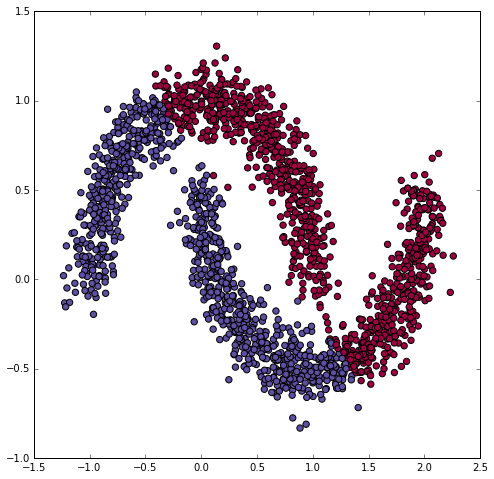

In [11]:
# moon
np.random.seed(2)
X, y = datasets.make_moons(2000, noise=0.1)

centers = kmeans(X, k=2)
labels = [find_closest_centroid(p, centers) for p in X]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

In [12]:
X

array([[ 0.55049533,  0.96527053],
       [ 0.07969976,  0.8986144 ],
       [ 0.26222506, -0.2274798 ],
       ..., 
       [ 0.087855  ,  1.0002636 ],
       [-0.00493096,  1.10047736],
       [ 0.28878349, -0.0237004 ]])

[array([ -0.01933866,   3.14557038,   3.37289705,  -0.7256364 ,
        -1.34700876,   3.60374116,  -1.18795892,   7.2315798 ,
        10.32216897,  -4.58833744,   5.77606699,   0.4640123 ,
         1.4464463 ,   7.74305834,  -9.83341156,  -9.74770502,
        -9.46613666,   6.74508007,   5.04431665,   6.61551694]), array([ 1.33152565,  4.75547343,  0.14539377,  1.1476545 , -2.39359794,
        3.72306234, -2.06267033,  7.58744336,  9.43079167, -2.03701349,
        5.6388553 ,  0.21989703,  0.41055663,  7.88370844, -9.95721291,
       -6.71828588, -9.49816623,  5.08745563,  6.18012837,  5.8257524 ]), array([  0.206354  ,   4.84303652,   1.38093486,   0.92949422,
        -2.16275009,   3.59431556,  -0.67166496,   7.62716126,
         9.66926192,  -3.42423113,   4.34324317,   1.0172901 ,
         1.52756472,   9.1469642 ,  -6.19613406,  -7.31293452,
       -10.50845428,   7.7694132 ,   4.24722761,   6.93865836])]


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


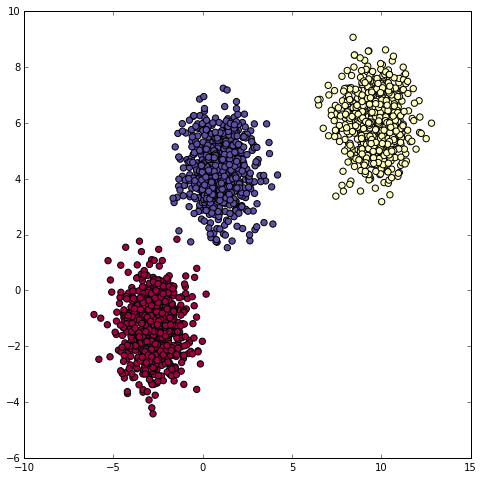

In [13]:
# blob
np.random.seed(1)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

<div class="alert alert-warning">

Figure 1:<br>
As we can see the iris data set (wikipedia reference) contains 4 features to perform the clustering but to plot it in 3D we should select 3 of them(in this code we ommitted the sepal width probably because it doesn't give a lot of information.<br>
We have a pretty good result in general but it depends on the random initialization of centroids.<br>

Figure 2:<br>
Using the moons representation, we get a wrong result since we had a simple linear separation, so the Kmeans algorithm is not suitable for that data.<br>

Figure 3:<br>
The KMeans algorithm gives a good result for this type of dataset but it's always dependent on the initial centroids.<br>
</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [1]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [2]:
np.random.seed(2)
def parseLine(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]

    # vector is every column, except the label
    vector = cols[:-1]

    # delete values of columns that have index 1->3 (categorical features)
    del vector[1:4]

    # convert each value from string to float
    vector = np.array([float(a) for a in vector])

    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()

# number of connections
n = data.count()

In [3]:
print(n)

4898431


#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [4]:
clusters = KMeans.train(data, 2, maxIterations=10,initializationMode="random")

In [5]:
pieChart = data.map(lambda x: (clusters.predict(x),1)).reduceByKey(add).collect()

In [6]:
pieChart

[(0, 2925804), (1, 1972627)]

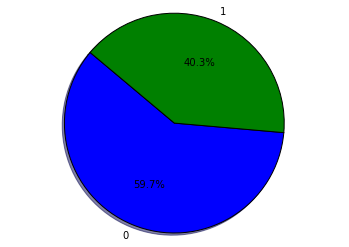

In [7]:
# Plot
plt.pie([pieChart[0][1],pieChart[1][1]],labels=[pieChart[0][0],pieChart[1][0]],autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


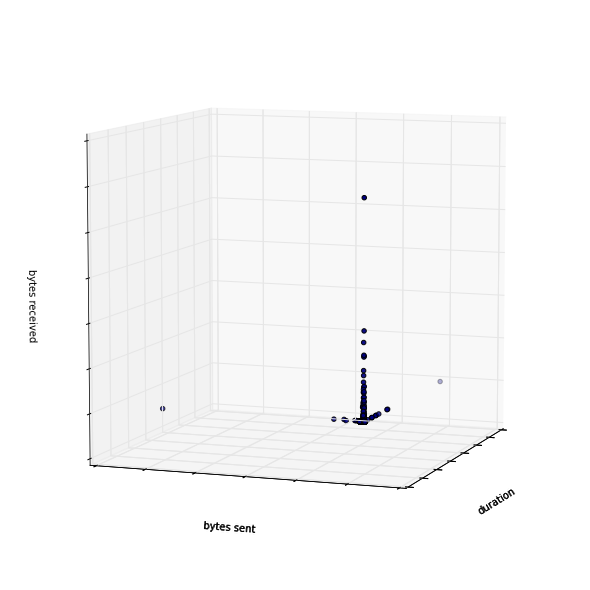

In [157]:
data2=data.takeSample(False,1000,1)
X_iris = np.array(data2)


# do the clustering
centers = clusters.centers
labels = [clusters.predict(point) for point in data2]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 0], X_iris[:, 1], X_iris[:, 2], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('duration')
ax.set_ylabel('bytes sent')
ax.set_zlabel('bytes received')

plt.show()

<div class="alert alert-warning">

The pie chart show the percentage of connections that are in the two clusters. The chart has no meaning because the totality of the points belong to one cluster. Here we tried to group normal behaviour and the abnormal one, but we didn't succeed since we didn't get a good definition of anomaly.

</div>

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [24]:
def error(clusters,point):
    center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(center,point)

WSSSE = data.map(lambda point: error(clusters,point)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))


Within Set Sum of Squared Error = 18744144324.0


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

In [23]:
clusterLabelCount = labelsAndData.map(lambda x: ((clusters.predict(x[1]),x[0]),1)).reduceByKey(add).collect()

for item in clusterLabelCount:
    print(item)

((0, 'nmap.'), 2316)
((0, 'ftp_write.'), 8)
((0, 'smurf.'), 2807886)
((0, 'pod.'), 264)
((0, 'normal.'), 972781)
((0, 'teardrop.'), 979)
((0, 'rootkit.'), 10)
((0, 'phf.'), 4)
((0, 'multihop.'), 7)
((0, 'perl.'), 3)
((1, 'portsweep.'), 5)
((0, 'land.'), 21)
((0, 'spy.'), 2)
((0, 'warezclient.'), 1020)
((0, 'back.'), 2203)
((0, 'ipsweep.'), 12481)
((0, 'guess_passwd.'), 53)
((0, 'buffer_overflow.'), 30)
((0, 'satan.'), 15892)
((0, 'loadmodule.'), 9)
((0, 'imap.'), 12)
((0, 'neptune.'), 1072017)
((0, 'warezmaster.'), 20)
((0, 'portsweep.'), 10408)


In [24]:
len(clusterLabelCount)

24

<div class="alert alert-warning">

As expected from the previous question all points belongs basically to one cluster, and the other cluster contains 5 datapoint from the label "portsweep".<br>
PS: "portsweep" also appears in the dominant cluster, and that's why we said the k=2 wasn't a proper way to define anomaly.

</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

1302333756836.467
295129657669.70715
1302329912286.272
237842637212.19257
237828367834.9853
237841318307.56192
237830640076.29034
203043046149.5753
235635231952.44208
223503348347.7222
235655153232.19846
203073252711.5017
223568521874.57764
203022430684.02414
233011941208.59995
202979230271.24908
223431519601.35944
223464741282.84058
232991880192.99228
202210459125.57245
202913432707.8388
197274648214.58588
233041501223.22903
571683954176.5593
223396218996.85162
202925006947.9724
233133968468.6904
223296449344.61563
223027702842.97287
221442484368.1988
223398889359.11172
168314802405.355


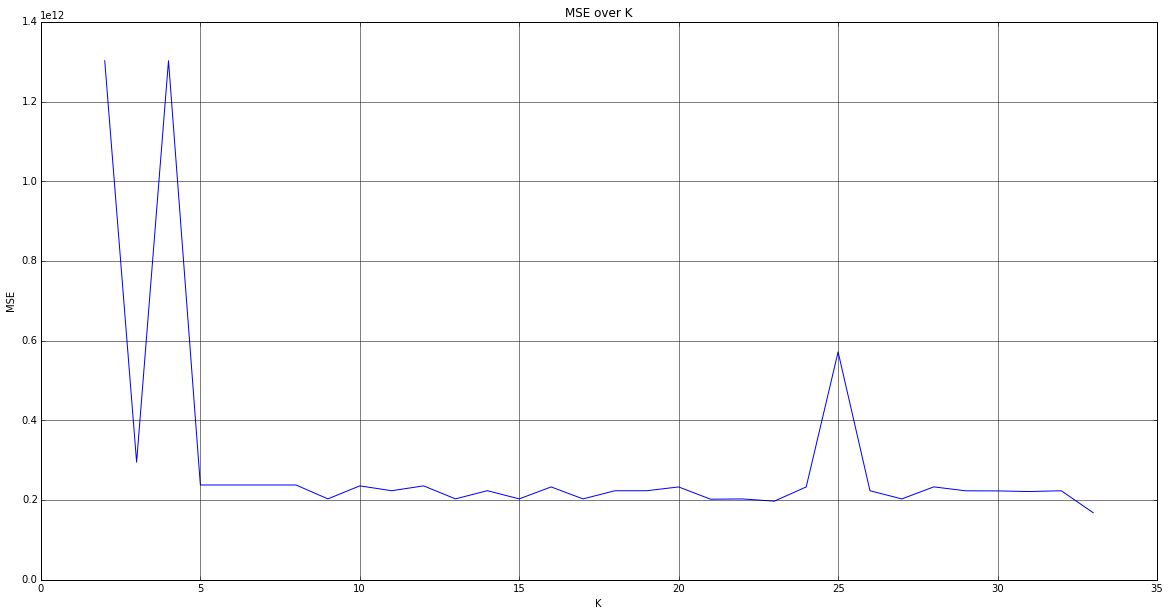

In [25]:
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10,initializationMode="random")
    # calculate mean square error
    return clusters.computeCost(data)/n
#data.map(lambda point: (point-clusters.predict(point))*(point-clusters.predict(point)))

scores = [clusteringScore(data,x) for x in range(2,len(clusterLabelCount)+10)]
for score in scores:
    print(score)

# plot results
plt.figure(figsize=(20,10))
plt.xlabel("K")
plt.ylabel("MSE")
plt.title('MSE over K')
plt.grid(True,which="both",ls="-")
plt.plot(range(2,len(clusterLabelCount)+10),scores)
plt.show()

<div class="alert alert-warning">
Each run we notice that the values are somehow different. The clustering depends on a randomly chosen initial set of centroids.
The results shows that the score decreases as k increase.But sometimes we notice an increase and this shouldn’t happen, because higher k always lead to a better clustering compared to a lower k. The problem is that K-means is not necessarily able to find the optimal clustering for a given k. Its iterative process can converge from a random starting point to a local minimum, which may be good but not optimal.<br>
As the graph shows,we can fix for the moment k=33, since it has the lowest MSE.

</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [ ]:
def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate the sum of each feature
    #sums = data.reduce(add)
    #print(sums)

    # calculate means
    means = data.mean()#[x/n for x in sums]

    # calculate the sum square of each feature
    #sumSquares = data.map(lambda x:np.square(x)).reduce(add)
    #print(sumSquares)

    # calculate standard deviation of each feature
    stdevs = data.stdev()#np.subtract(np.divide(sumSquares,n),np.square(means))
    #print(stdevs)

    def normalize(point):
        return [a/b if(b!=0) else a for a,b in zip(np.subtract(point,means),stdevs)]

    return data.map(normalize)

normalizedData = normalizeData(data).cache()

In [167]:
print(np.array(normalizedData.take(5)))

[[ -6.68331854e-02  -1.72038228e-03   6.81884351e-02  -2.39084686e-03
   -1.51391734e-02  -1.10348462e-03  -2.65207600e-02  -4.39091558e-03
    2.44279187e+00  -2.09732783e-03  -8.25770840e-03  -4.54646139e-03
   -3.28458917e-03  -9.57233922e-03  -8.50457842e-03  -2.87561127e-02
    0.00000000e+00  -6.38979005e-04  -2.89113034e-02  -1.57541507e+00
   -1.19624324e+00  -4.66042614e-01  -4.65755574e-01  -2.48285775e-01
   -2.48130352e-01   5.39733093e-01  -2.56056520e-01  -2.01059296e-01
   -3.63913926e+00  -1.78651044e+00  -1.83302273e+00  -2.82939000e-01
   -1.25793664e+00  -1.56668488e-01  -4.66404784e-01  -4.65453641e-01
   -2.50831829e-01  -2.49631966e-01]
 [ -6.68331854e-02  -1.77667956e-03   5.32451452e-03  -2.39084686e-03
   -1.51391734e-02  -1.10348462e-03  -2.65207600e-02  -4.39091558e-03
    2.44279187e+00  -2.09732783e-03  -8.25770840e-03  -4.54646139e-03
   -3.28458917e-03  -9.57233922e-03  -8.50457842e-03  -2.87561127e-02
    0.00000000e+00  -6.38979005e-04  -2.89113034e-02 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

202205688716.42166
202241916280.83362
197200647137.25055
197203268281.24722
197207282683.0804
197200729628.35413


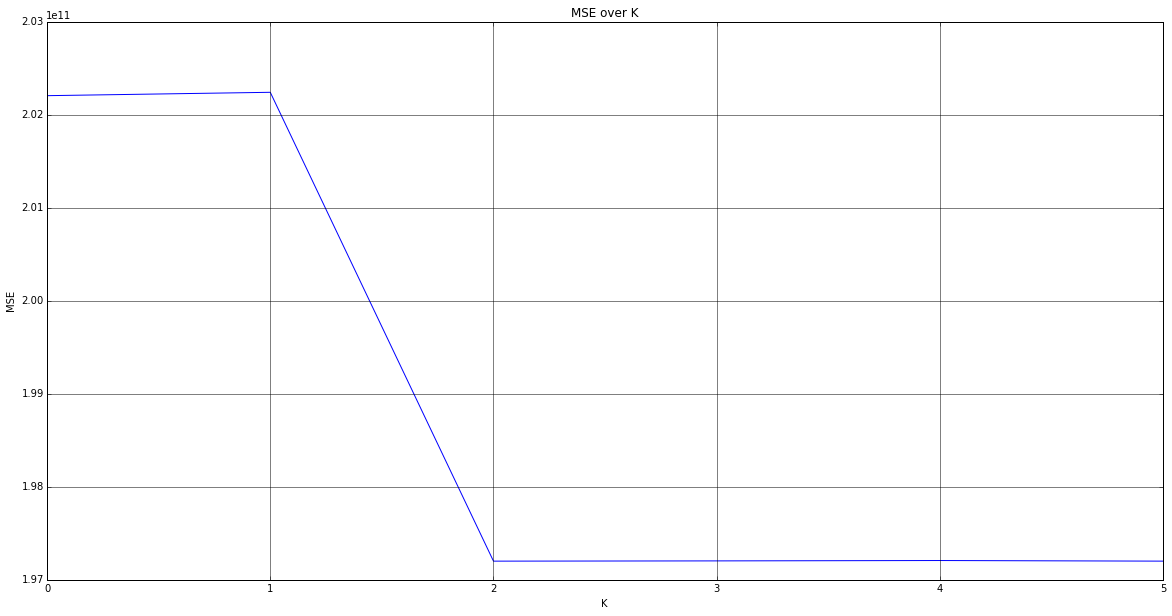

In [27]:
scores = [clusteringScore(data,x) for x in [60,70,80,90,100,110]]
for score in scores:
    print(score)

# plot results
plt.figure(figsize=(20,10))
plt.xlabel("K")
plt.ylabel("MSE")
plt.title('MSE over K')
plt.grid(True,which="both",ls="-")
plt.plot(range(len([60,70,80,90,100,110])),scores)
plt.show()

<div class='alert alert-warning'>
Since the scoring results change each run (because there is the random initialization when training KMeans), we'll just take one of the lowest scoring values (k [80,90,100,110]).<br>
So we will take k=110.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

<div class="alert alert-warning">

So to be able to plot this the clustering result :<br>
    1- to see the difference we should only print a part of the data not all of them.<br>
    2- we should reduce the dimensions of our vectors to at most 3 dimensions (either using principal component analysis or just simple projection of the relevent feature; the most informative)<br>

</div>

In [172]:
type(data)

pyspark.rdd.PipelinedRDD

In [173]:
data_part=data.takeSample(False,10000,2)

In [174]:
np.array(data_part)[0:5,1]

array([ 1032.,  1032.,     0.,  1032.,  1032.])

In [175]:
normalizeddata_part=normalizeData(sc.parallelize(data_part)).collect()

[  5.64150330e+02   2.20033422e+04   3.08443099e+04   0.00000000e+00
   5.19537294e-02   0.00000000e+00   3.76566050e-01   0.00000000e+00
   3.51798110e-01   4.24146201e-02   0.00000000e+00   0.00000000e+00
   1.60568864e-01   1.41407213e-02   9.99949999e-03   2.23550889e-02
   0.00000000e+00   0.00000000e+00   2.64482514e-02   2.12688358e+02
   2.45944496e+02   3.78185133e-01   3.78642942e-01   2.33802079e-01
   2.34480931e-01   3.87154127e-01   8.21960794e-02   1.34969989e-01
   6.47925401e+01   1.05679182e+02   4.09427457e-01   1.07080277e-01
   4.80529467e-01   3.81787110e-02   3.78043622e-01   3.78443562e-01
   2.31667253e-01   2.32094947e-01]


In [40]:
np.array(normalized).shape


(10000, 38)

In [32]:
type(data_part[0][0])

numpy.float64

In [189]:
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans as km
pca=PCA(n_components=2)
d1=pd.DataFrame(pca.fit_transform(data_part))

d2=pd.DataFrame(pca.fit_transform(normalizeddata_part))
model=km(n_clusters=10,n_init=5)

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


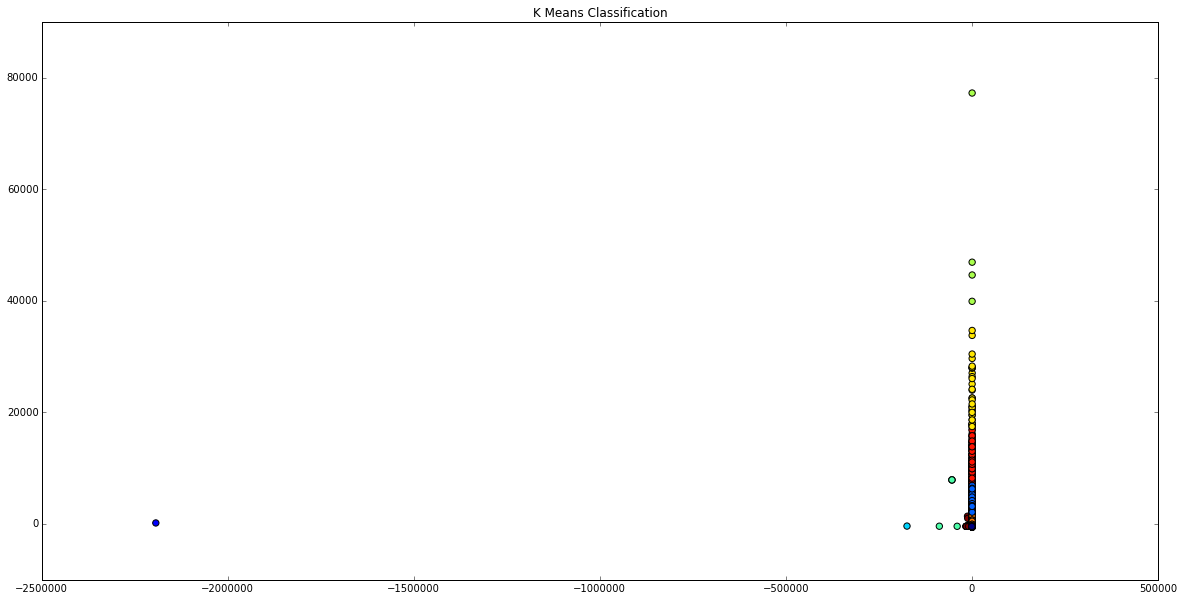

In [85]:
#we used here the KMEANS implementation of the library sklearn
d1.columns=["f1","f2"]
model.fit(d1)
plt.figure(figsize=(20,10))
plt.scatter(d1.f1,d1.f2,c=[model.labels_],s=40)
plt.title('K Means Classification')

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


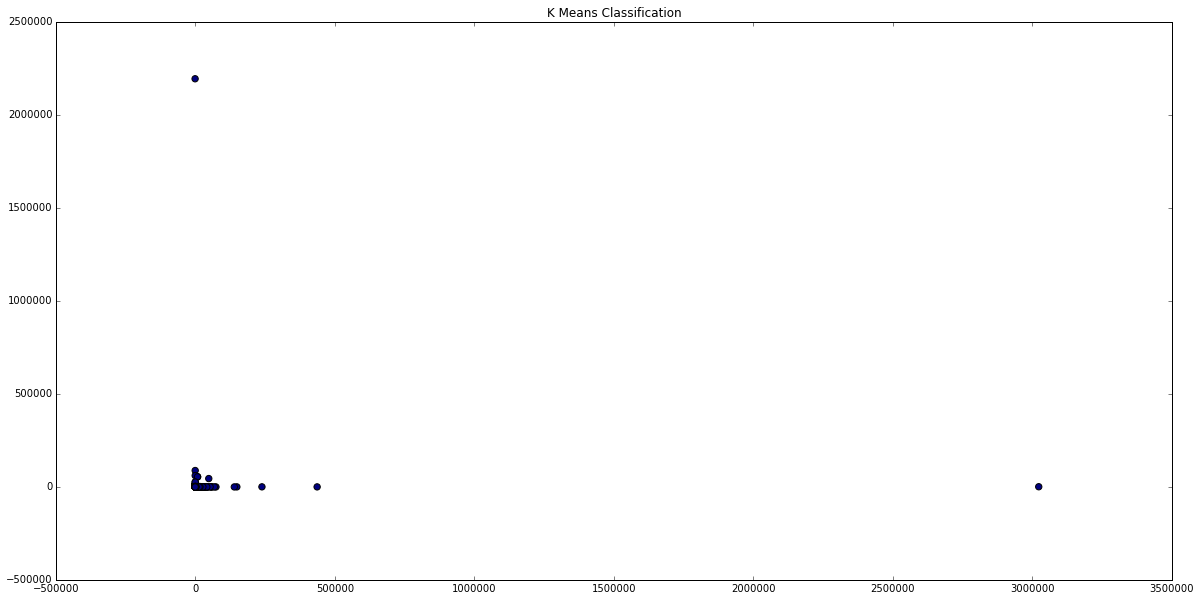

In [198]:
#Mllib Kmeans
d2.columns=["f1","f2"]
centers = clusters_1.centers
labels = [clusters_1.predict(point) for point in normalizeddata_part]
plt.figure(figsize=(20,10))
plt.scatter(d1.f1,d1.f2,c=labels,s=40)
plt.title('K Means Classification')

In [192]:
clusters_1 = KMeans.train(data, 30, maxIterations=10,initializationMode="random")

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


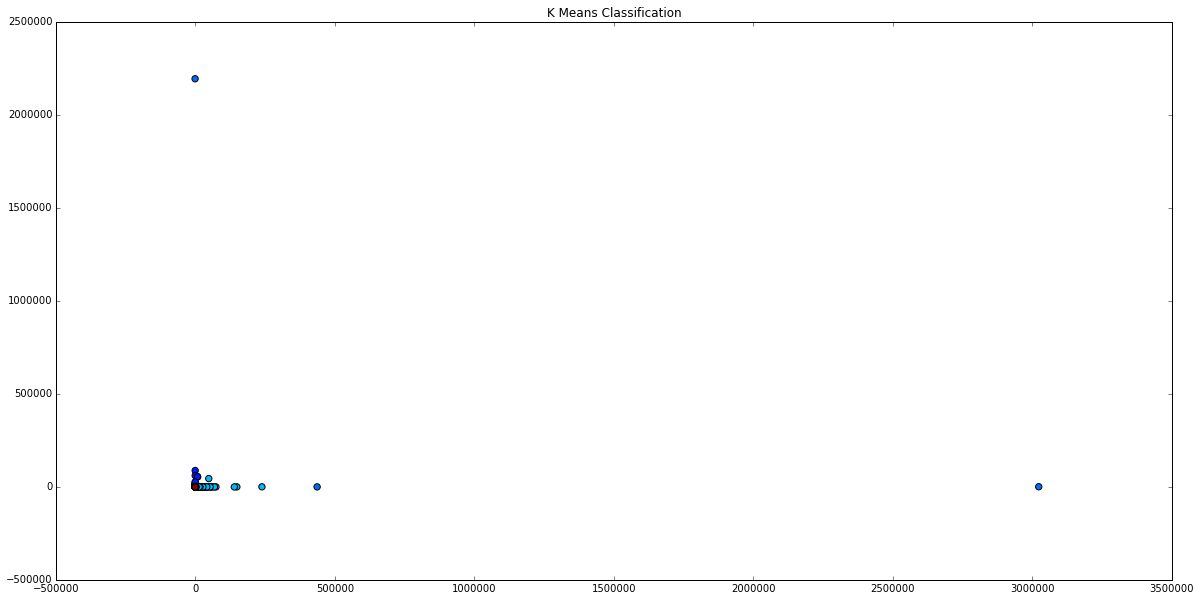

In [195]:
#Mllib Kmeans
centers = clusters_1.centers
labels = [clusters_1.predict(point)  for point in data_part]
d1.columns=["f1","f2"]
plt.figure(figsize=(20,10))
plt.scatter(d1.f1,d1.f2,c=labels,s=40)
plt.title('K Means Classification')

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


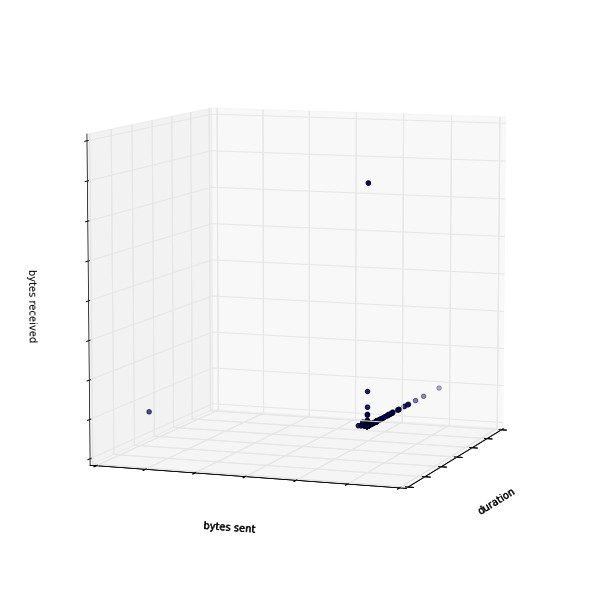

In [185]:

# load data 
X_iris = np.array(data_part)


# do the clustering
centers = clusters.centers
labels = [clusters.predict(point)  for point in data_part]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 0], X_iris[:, 1], X_iris[:, 2], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('duration')
ax.set_ylabel('bytes sent')
ax.set_zlabel('bytes received')

plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


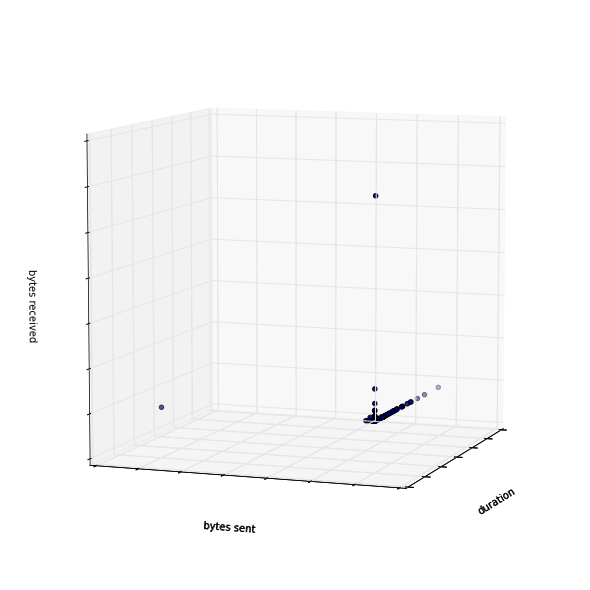

In [182]:
# load data 
X_iris = np.array(normalizeddata_part)


# do the clustering
centers = clusters.centers
labels = [clusters.predict(point)  for point in normalizeddata_part]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 0], X_iris[:, 1], X_iris[:, 2], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('duration')
ax.set_ylabel('bytes sent')
ax.set_zlabel('bytes received')

plt.show()

<div class="alert alert-warning">


From theoretical point of view normalizing should be have a good impact on the clustering, since in our data we have a lot of 0/1 features but also we have at least 3 features that have unlimited value (duration,bytes sent, bytes received), So dividing by the standard deviation will has a better effect in the clustering

</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

```python
def parseLineWithHotEncoding(line):
    cols = line...
    # label is the last column
    label = ...
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = ...
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = ...
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = ...
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(...)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()


normalizedData = normalizeData(data).cache()
```

In [26]:
def getValuesOfColumn(data, c):
    return data.map(lambda x: x[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndDataHot = raw_data.map(parseLine)

# we only need the data, not the label
dataHot = labelsAndDataHot.values().cache()

In [27]:
normalizedData = normalizeData(dataHot).cache()

[  7.23329737e+02   9.41430978e+05   6.45012268e+05   2.39083319e-03
   4.28543324e-02   7.21508295e-03   4.68978117e-01   7.29940683e-03
   3.50611523e-01   3.85648064e+00   8.25714534e-03   8.08243095e-03
   3.93807490e+00   1.24185736e-01   8.73758872e-03   3.55104777e-02
   0.00000000e+00   6.38978745e-04   2.88871577e-02   2.11990761e+02
   2.45992685e+02   3.81875553e-01   3.82254047e-01   2.32252900e-01
   2.32660379e-01   3.89295798e-01   8.27145751e-02   1.40559550e-01
   6.40209308e+01   1.05912757e+02   4.11185973e-01   1.08543203e-01
   4.80987669e-01   4.12597750e-02   3.81838168e-01   3.82177399e-01
   2.30942796e-01   2.30977686e-01]


In [168]:
labelsAndDataHot_1 = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
dataHot_1 = labelsAndDataHot_1.values().cache()
normalizedData_1 = normalizeData(dataHot_1).cache()

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [116]:
scoresN = []
for x in [80,90,100,110,120,130,140,150,160]:
    scoresN.append([clusteringScore(normalizedData,x) for y in range(5)])
    
for score in scoresN:
    print(score)

[14.287131124824912, 12.370418791753329, 13.384979081585094, 12.337258289013622, 14.413457323131663]
[12.280063032257331, 11.646785528163623, 13.282545658812248, 12.231397877105817, 14.250169105357902]
[12.415368671215361, 11.461787356480835, 11.351205583534783, 13.510576381450395, 12.373276188915703]
[11.635770160567912, 13.606935114354231, 13.580674120116322, 12.49757887819935, 13.439796094979053]
[9.414058539161484, 14.4298171985762, 13.402650939055423, 12.016457802442158, 13.474746581938518]
[13.442243466343662, 10.199702346678967, 12.30159300768661, 12.781522242977047, 13.221036530833764]
[10.232003613576573, 12.029687473978544, 13.483375385452531, 11.244531327083484, 10.148039016352215]
[12.19000121510514, 11.38773409611985, 12.608268706240263, 12.309469283906308, 12.00980714062349]
[12.801017923691832, 10.702217822817047, 11.244192427532516, 10.32757198797855, 13.035013602582598]


In [124]:
score = [np.mean(x) for x in scoresN]
for s in score:
    print(s)

13.3586489221
12.7381922403
12.2224428363
12.9521508736
12.5475462122
12.3892195189
11.4275273633
12.1010560884
11.6220027529


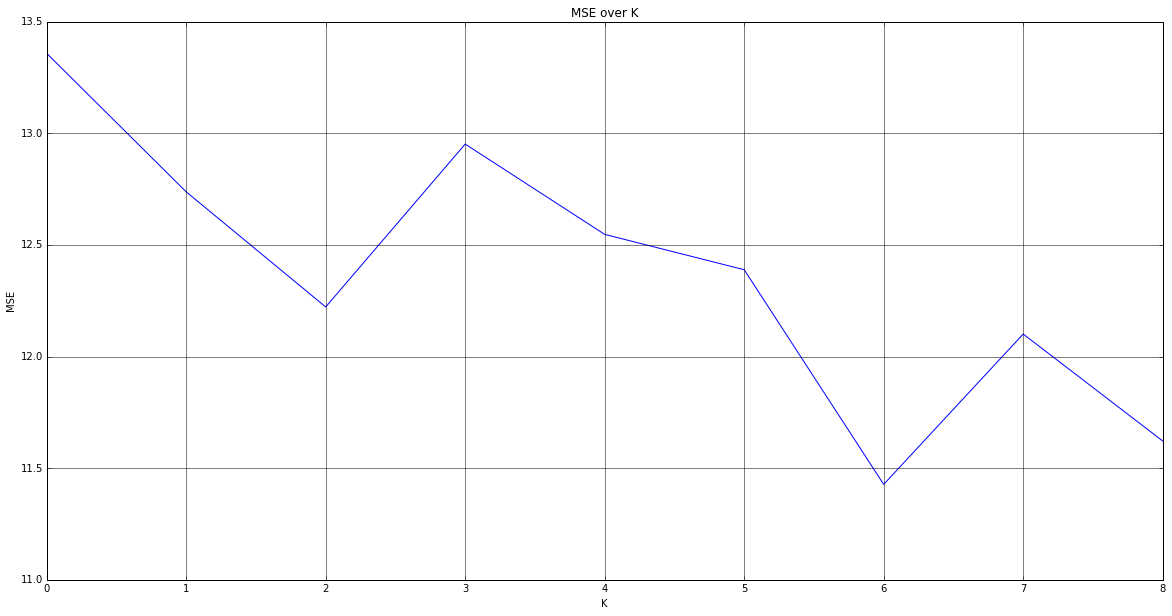

In [123]:
# plot results
plt.figure(figsize=(20,10))
plt.xlabel("K")
plt.ylabel("MSE")
plt.title('MSE over K')
plt.grid(True,which="both",ls="-")
plt.plot(range(len([80,90,100,110,120,130,140,150,160])),score)
plt.show()

<div class="alert alert-warning">

To have a refined scoring result, for each value of k we run 5 times.
As the graph shows, we obtained a decreasing curve as a general behaviour (but we still have some ups showing some local optimum).<br>
Since we used the normalized data and the categorical features, we obtained a much better result in terms of MSE.
We choose as always the lowest value of MSE corresponding to K=140


</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [28]:
clustersBig = KMeans.train(normalizedData, 140, maxIterations=15,initializationMode="random")

WSSSE = normalizedData.map(lambda point: error(clustersBig,point)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))


Within Set Sum of Squared Error = 1500188.59341


In [65]:
clusterLabelCount = normalizedData.map(lambda x: (clustersBig.predict(x),1)).reduceByKey(add).collect()

for item in clusterLabelCount:
    print(item)

(0, 347035)
(48, 149749)
(36, 4090)
(24, 6805)
(60, 33941)
(12, 26078)
(72, 102926)
(1, 4576)
(37, 1466)
(73, 46582)
(49, 49554)
(25, 47941)
(13, 11556)
(61, 5162)
(2, 40708)
(74, 33837)
(14, 8013)
(38, 30355)
(26, 22160)
(50, 3195)
(62, 36253)
(3, 11699)
(75, 33906)
(51, 119445)
(39, 32071)
(15, 14213)
(27, 27931)
(63, 54497)
(64, 52846)
(76, 2337)
(4, 451)
(16, 34453)
(40, 70174)
(52, 23135)
(28, 28052)
(17, 10497)
(53, 102189)
(65, 122)
(41, 31086)
(29, 14798)
(77, 41227)
(5, 12321)
(18, 46211)
(78, 27954)
(6, 30318)
(42, 15919)
(54, 327)
(66, 23223)
(30, 28994)
(67, 10412)
(19, 23019)
(55, 6722)
(7, 2267979)
(79, 37772)
(43, 15176)
(31, 6478)
(32, 9958)
(56, 970)
(68, 58581)
(8, 5206)
(20, 29598)
(44, 4853)
(33, 15566)
(21, 36977)
(57, 34479)
(9, 11674)
(45, 38238)
(69, 25016)
(34, 43426)
(70, 32024)
(22, 12130)
(58, 42233)
(10, 17907)
(46, 25335)
(59, 38518)
(35, 18571)
(23, 33226)
(71, 10792)
(11, 29260)
(47, 53957)


In [49]:
dst = normalizedData.map(lambda point: error(clustersBig, point))
dstOrd = dst.takeOrdered(500,lambda x: -x)

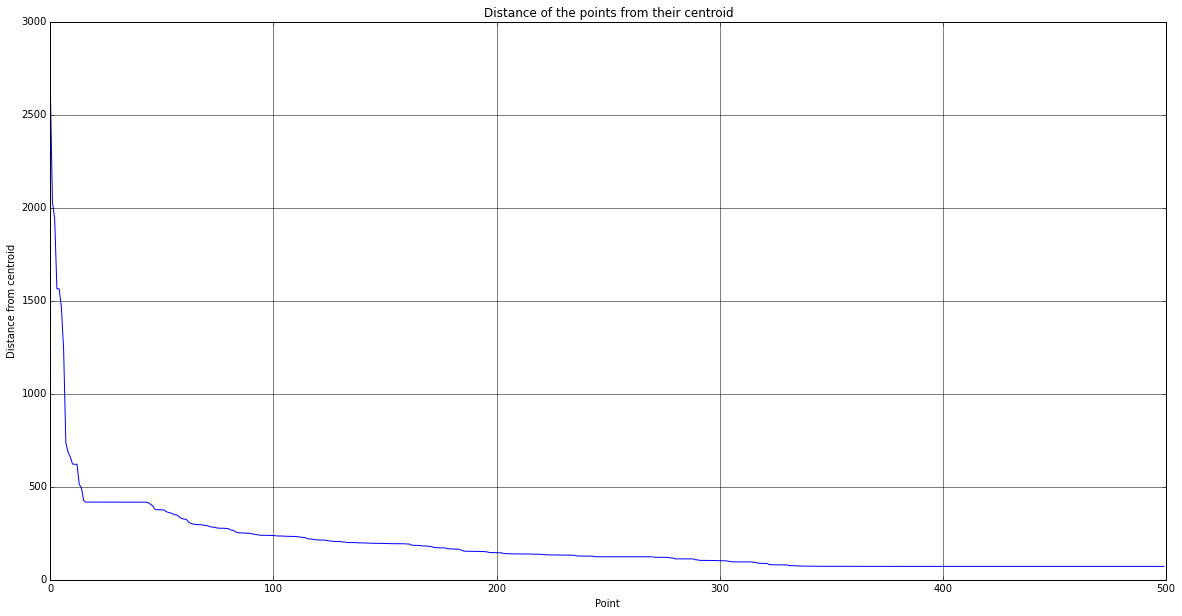

In [50]:
# plot results
plt.figure(figsize=(20,10))
plt.xlabel("Point")
plt.ylabel("Distance from centroid")
plt.title('Distance of the points from their centroid')
plt.grid(True,which="both",ls="-")
plt.plot(range(len(dstOrd)),dstOrd)
plt.show()

<div class="alert alert-warning">
The 100th-farthest data point is not a good point of reference as a threshold to define a point anomalous or not. This because the curve is still decreasing. From the graph, a good point of reference can be the 330th-farthest data point because after that the values of distance remains constant. <br>
We can also differenciate between a suspicious anomaly and a real detectable anomaly putting the threshold in the 25th-farthest because before those value the distances grows very fast. 
</div>

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

For the silouhette alg for a(i) is crazy to take the average distance between the point i and his neighbours in the same cluster (computationally speaking) so a reasonable value can be the average distance of the points to their centroid or simply the distance between the point and the centroid.

For b(i) we can simply chose the minimum distance between the point and the centroid of the others clusters

In [29]:
def minDistance(point,clusters):
    distances = []
    for y in clusters.centers:
        distances.append(euclidean_distance(y,point))
    del distances[distances.index(np.min(distances))]
    return np.min(distances)

#first is A(i) second is B(i)
silhouetteData = normalizedData.map(lambda x: (clustersBig.predict(x),(error(clustersBig,x),minDistance(x,clustersBig))))

In [30]:
silhouetteRes = silhouetteData.map(lambda x: (x[0],(x[1][1]-x[1][0])/np.max(x[1]))).cache()

In [34]:
meanSil = silhouetteRes.map(lambda x: x[1]).mean()

In [35]:
meanSil

0.71877898279486607

In [36]:
goodSilh = silhouetteRes.map(lambda x: (1,1) if (x[1]>=meanSil) else (0,1)).reduceByKey(add).collect()

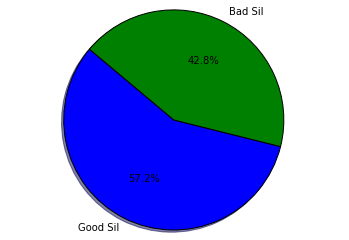

In [37]:
plt.pie([goodSilh[1][1],goodSilh[0][1]],labels=["Good Sil","Bad Sil"],autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [51]:
goodSilhClu = silhouetteRes.map(lambda x: (x[0],(1,1)) if (x[1]>=meanSil) else (x[0],(0,1))).reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1])).collect()


In [52]:
for x in range(len(goodSilhClu)):
    print(goodSilhClu[x])

(0, (21, 1223))
(48, (2557, 33847))
(36, (718, 37823))
(84, (0, 34122))
(72, (2088, 7944))
(60, (0, 1457))
(12, (886, 13748))
(24, (6422, 51176))
(1, (26326, 56939))
(25, (48742, 100227))
(37, (0, 29189))
(49, (425, 5112))
(73, (94, 7069))
(61, (4885, 11307))
(85, (0, 29880))
(13, (4909, 32152))
(50, (2851, 43245))
(74, (52, 28020))
(62, (1480, 32891))
(38, (4747, 6421))
(26, (9039, 58258))
(2, (10, 24663))
(14, (0, 443))
(3, (171, 898))
(51, (1878, 56885))
(75, (4266, 33932))
(39, (2756, 42064))
(63, (5701, 53218))
(27, (11865, 48164))
(15, (6829, 46392))
(16, (1167, 15931))
(64, (69825, 83277))
(4, (864, 10219))
(76, (4515, 21420))
(40, (1085, 20082))
(52, (281, 4437))
(28, (7187, 16837))
(17, (6155, 35959))
(53, (4302, 4571))
(5, (1391, 101662))
(65, (581, 19036))
(41, (1744, 5924))
(29, (56, 138))
(77, (0, 332))
(18, (0, 33706))
(6, (2262816, 2267984))
(54, (23, 12020))
(42, (3191, 14374))
(78, (92, 123))
(66, (1518, 11660))
(30, (404, 4355))
(67, (521, 5228))
(19, (478, 19823))
(5

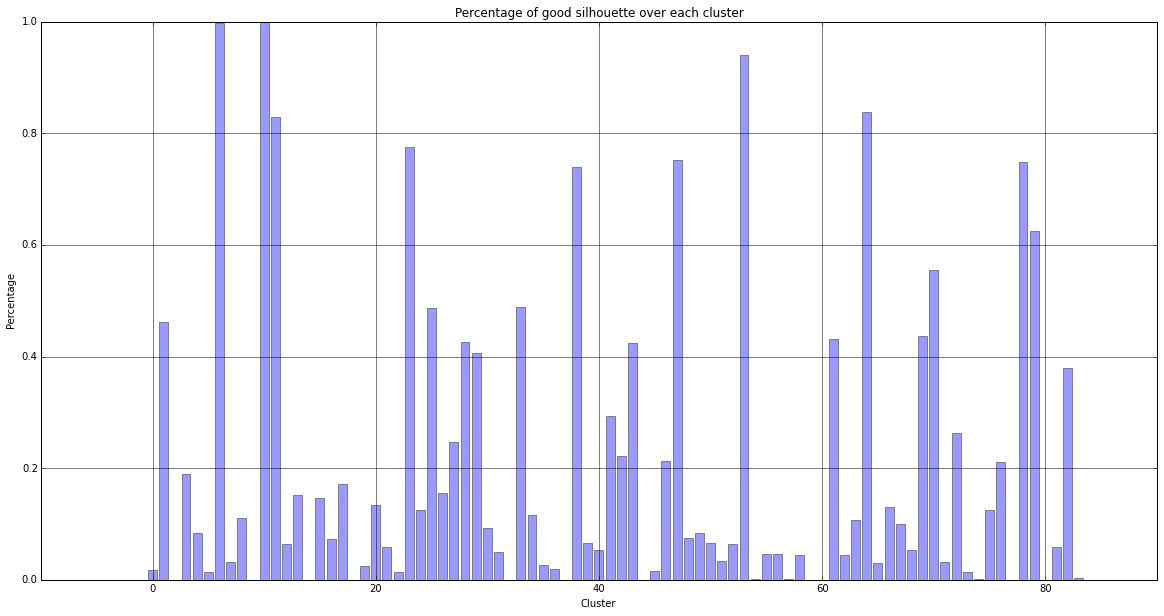

In [60]:
plt.figure(figsize=(20,10))
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.title('Percentage of good silhouette over each cluster')
plt.grid(True,which="both",ls="-")

# plot bar chart
plt.bar([x[0] for x in  goodSilhClu],[x[1][0]/(x[1][1]*1.0) for x in goodSilhClu], align='center', alpha=0.4)

plt.show()


<div class="alert alert-warning">
Note: as A(i) value we took the distance between the point and its centroid. Because using the definition of A(i) require to much computation time.
The mean value of the silhouette over all the point is not too far from 1. This means that most of the points are well assigned to their centroids.
The pie chart shows the percentage of points that have a silhouette value greater (58%) or lower (42%) than the mean one.
The above graphs show the percentage of the points that have a silhouette value greater than the mean one grouped by their clusters. It shows that there are some clusters that are well defined where the points are closer to their centroids and some clusters that have their points very far from the centroids.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>

In [61]:
def find_closest_centroid_RDD(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    lst = [euclidean_distance(datapoint, x) for x in centroids]
    minLst = np.min(lst)
    return lst.index(minLst)

In [62]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids_RDD(centroids, cluster):
    for x in range(len(cluster)):
        sumPoints = [0 for i in range(len(cluster[0][0]))]
        for y in range(len(cluster[x])):
            sumPoints = [np.sum(j) for j in zip(sumPoints,(cluster[x][y]))]
        centroids[x] = [a/len(cluster[x]) for a in sumPoints]
    return centroids

In [149]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
    
def kmeansRDD(data, k=2, centroids=None):

    # randomize the centroids if they are not given
    if not centroids:
        centroids = data.takeSample(False,k)
    print(centroids)
    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        # find the closest center of each data point
        #print(point)
        centroid_idx = data.map(lambda x: (find_closest_centroid(x,centroids),x)) #find_closest_centroid(point, centroids)

        #print(clusters)
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        # update centroids
        centroidsSum = centroid_idx.combineByKey(lambda value: (value, 1),lambda x, value: ((np.array(x[0]) + np.array(value)), x[1] + 1),lambda x, y: ((np.array(x[0]) + np.array(y[0])), x[1] + y[1]))#update_centroids(old_centroids, clusters)
        centroids = centroidsSum.map(lambda x:   np.divide(np.array(x[1][0]),x[1][1]).tolist()  ).collect()
        # if the stop criteria are met, stop the algorithm
        if (check_converge(centroids, old_centroids, iterations)):
            break

    return centroids

In [160]:
mapred_data=normalizedData.takeSample(False,10000,1)
centroidsRDD = kmeansRDD(sc.parallelize(mapred_data),10)

[[-0.06683318542420881, -0.0016927647504702125, -0.00093118044973796203, -0.002390846860871979, -0.015139173434022768, -0.0011034846181947316, -0.02652075995496225, -0.0043909155847363995, 2.4427918743642953, -0.0020973278346870065, -0.0082577083974692041, -0.004546461386643566, -0.0032845891671851204, -0.0095723392157848041, -0.0085045784245865279, -0.028756112730865285, 0.0, -0.00063897900545820054, -0.028911303443117074, -1.5706978877225637, -1.1759174304434037, -0.46604261387255441, -0.46575557391312739, -0.24828577490849504, -0.24813035170523645, 0.53973309269996084, -0.2560565202907733, 2.1467000616107046, -3.6078994756111777, 0.62113155412362142, 0.59896684321046056, -0.28293900018696772, -0.21840894954774653, 0.81279874657320395, -0.46640478356659043, -0.46545364052902638, -0.25083182898698642, -0.2496319657767273], [-0.06683318542420881, -0.00085255445555542167, -0.0016955069975137802, -0.002390846860871979, -0.015139173434022768, -0.0011034846181947316, -0.02652075995496225, 

In [162]:
def errorRDD(point):
    center = centroidsRDD[find_closest_centroid_RDD(point,centroidsRDD)]
    return euclidean_distance(center,point)

In [163]:
WSSSE = sc.parallelize(mapred_data).map(lambda point: errorRDD(point)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 10710.7275528


<div class="alert alert-warning">
The code is runnable but we tested it with few data because of computation time was higher than using the implementation of MLLib.
</div>